# Neural Network

## Read data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30000 non-null  object
 1   label   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


,text,label
0,Tim Burton is in essence an expressionist film...,1
1,This tale based on two Edgar Allen Poe pieces ...,1
2,"Dead or Alive: Final, the movie that supposedl...",1
3,Certainly this film has the ring of truth abou...,1
4,It pains me to say this about an Australian fi...,0


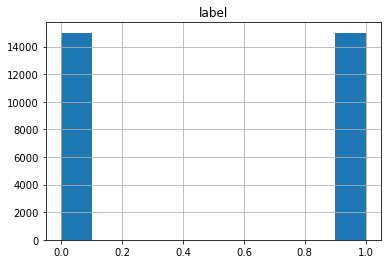

In [1]:
import pandas as pd

df_train = pd.read_json("../data/aclIMDB_train.json", orient="records")
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This was Barbra Streisand's first television s...,1
1,"I am, as many are, a fan of Tony Scott films. ...",0
2,A young scientist Harry Harrison is continuing...,0
3,"Anthony McGarten has adapted his play, Via Sat...",1
4,"I was watching this movie on Friday,Apr 7th. I...",1


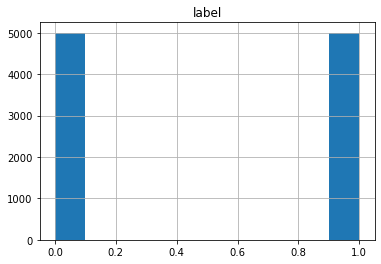

In [2]:
df_val = pd.read_json("../data/aclIMDB_val.json", orient="records")
df_val.info()
df_val.hist()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This movie features Charlie Spradling dancing ...,0
1,L'Hypothèse du tableau volé/The Hypothesis of ...,1
2,Surprisingly well made little movie. Short in ...,1
3,I rented this because I'm a bit weary of '80s ...,0
4,"Twenty years ago, the five years old boy Micha...",0


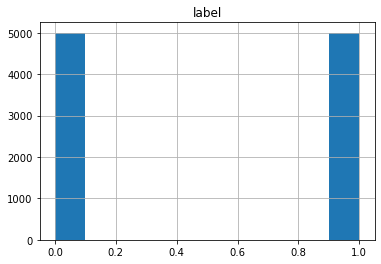

In [3]:
df_test = pd.read_json("../data/aclIMDB_test.json", orient="records")
df_test.info()
df_test.hist()
df_test.head()

## Preprocessing

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

STOPWORDS = stopwords.words("english")

def is_html_tag(word):
    w = word.replace("\n", "")
    return w.startswith("<") or w.startswith(">") or w.startswith("/") or w.strip()[:2] == "br"

def remove_html_tags(sentence):
    single_spaces = " ".join(sentence.split())

    return " ".join([token for token in single_spaces.split(" ") if not is_html_tag(token)])

def tokenize_sentence(sentence):
    return word_tokenize(sentence.lower())

def remove_stopwords(sentence):
    return " ".join([word for word in sentence.split(" ") if not word in STOPWORDS])

def remove_punctuation(tokenized_sentence):
    return [word for word in tokenized_sentence if word.isalpha()]

def preprocess(sentence):
    return remove_punctuation(tokenize_sentence(remove_stopwords(remove_html_tags(str(sentence)))))

print(preprocess(df_train["text"].values[1]))


['this', 'tale', 'based', 'two', 'edgar', 'allen', 'poe', 'pieces', 'the', 'fall', 'house', 'usher', 'dance', 'death', 'poem', 'actually', 'quite', 'creepy', 'beginning', 'end', 'it', 'similar', 'old', 'movies', 'people', 'meet', 'old', 'decrepit', 'house', 'for', 'example', 'the', 'cat', 'canary', 'the', 'old', 'dark', 'house', 'night', 'terror', 'on', 'boris', 'karloff', 'plays', 'demented', 'inventor', 'dolls', 'terrorize', 'guests', 'he', 'dies', 'early', 'film', 'or', 'residents', 'house', 'subjected', 'number', 'terrifying', 'experiences', 'i', 'go', 'much', 'detail', 'here', 'definitely', 'fans', 'old', 'dark', 'house', 'br', 'plenty', 'popcorn', 'soda', 'darkened', 'br', 'basinger']


In [5]:
def sentiment(value):
    if(value == 1):
        return "positive"
    else:
        return "negative"

df_train["sentiment"] = [None] * len(df_train)
df_train["sentiment"] = df_train["label"].apply(sentiment)
df_val["sentiment"] = [None] * len(df_test)
df_val["sentiment"] = df_val["label"].apply(sentiment)
df_test["sentiment"] = [None] * len(df_test)
df_test["sentiment"] = df_test["label"].apply(sentiment)

In [6]:
df_train["text"] = df_train["text"].apply(preprocess)
df_train.head()

,text,label,sentiment
0,"[tim, burton, essence, expressionist, disinter...",1,positive
1,"[this, tale, based, two, edgar, allen, poe, pi...",1,positive
2,"[dead, alive, final, movie, supposedly, togeth...",1,positive
3,"[certainly, film, ring, truth, it, purports, b...",1,positive
4,"[it, pains, say, australian, film, accident, r...",0,negative


In [7]:
def build_vocab(tokenized_input, vocab_size):
    d = dict()

    for tokens in tokenized_input:
        for token in tokens:
            # double check
            if token not in STOPWORDS and token.isalpha():
                d[token] = d.get(token, 0) + 1

    del d["br"]

    return {k for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)[:vocab_size]}

In [8]:
VOCAB_SIZE = 10000
VOCAB = build_vocab(df_train["text"].values, VOCAB_SIZE) # (!) Always build the vocabulary on the TRAIN dataset

In [9]:
def get_frequencies_for_sentiment(df):
    dict_freqs = {"positive": {}, "negative": {}}
    
    for idx in range(df.shape[0]):
        tokens = df_train.iloc[idx]["text"]
        sentiment = df_train.iloc[idx]["sentiment"]
        
        for token in tokens:
            if token in VOCAB:
                dict_freqs[sentiment][token] = dict_freqs[sentiment].get(token, 0) + 1
            
    return dict_freqs

In [10]:
frequency_table = get_frequencies_for_sentiment(df_train)
frequency_table["positive"]["happy"]

608

In [11]:
import numpy as np

def extract_features(frequency_table, tokens):
    positives = 0
    negatives = 0

    for t in tokens:
        positives += frequency_table["positive"].get(t, 0)
        negatives += frequency_table["negative"].get(t, 0)
    
    return pd.Series({"positives": positives, "negatives": negatives})

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = df_train["text"].apply(lambda tokens: extract_features(frequency_table, tokens))

X_train = scaler.fit_transform(X_train)
y_train = df_train["label"].values

In [13]:
X_train.shape

(30000, 2)

In [14]:
df_val["text"] = df_val["text"].apply(preprocess)
X_val = df_val["text"].apply(lambda tokens: extract_features(frequency_table, tokens))
X_val = scaler.transform(X_val)
y_val = df_val["label"].values

## Create model and train / validate

In [15]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# https://keras.io/api/optimizers/
# https://keras.io/api/optimizers/adam/
# https://keras.io/api/losses/
# https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
# https://keras.io/api/metrics/accuracy_metrics/
# https://keras.io/api/metrics/
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy'])
              
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________


In [16]:
h = model.fit(X_train,
              y_train,
              validation_data=(X_val, y_val),
              epochs=10)

Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 0.5999 - binary_accuracy: 0.6801 - val_loss: 0.5879 - val_binary_accuracy: 0.6896
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5876 - binary_accuracy: 0.6903 - val_loss: 0.5883 - val_binary_accuracy: 0.6904
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5875 - binary_accuracy: 0.6908 - val_loss: 0.5895 - val_binary_accuracy: 0.6896
Epoch 4/10
938/938 [==============================] - 2s 3ms/step - loss: 0.5857 - binary_accuracy: 0.6913 - val_loss: 0.5934 - val_binary_accuracy: 0.6846
Epoch 5/10
938/938 [==============================] - 2s 3ms/step - loss: 0.5873 - binary_accuracy: 0.6890 - val_loss: 0.5898 - val_binary_accuracy: 0.6863
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5863 - binary_accuracy: 0.6884 - val_loss: 0.5891 - val_binary_accuracy: 0.6817
Epoch 7/10
938/938 [==============================] - 2s 2ms/ste

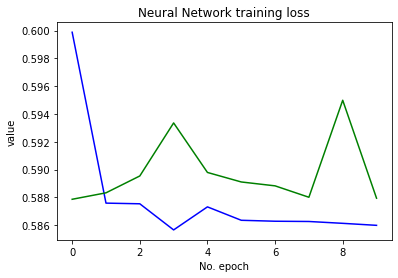

In [17]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='(training data)',color='blue')
plt.plot(h.history['val_loss'], label='(validation data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

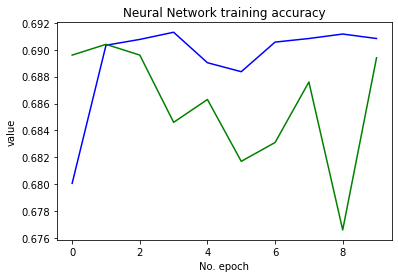

In [18]:
import matplotlib.pyplot as plt

plt.plot(h.history['binary_accuracy'], label='(training data)',color='blue')
plt.plot(h.history['val_binary_accuracy'], label='(validation data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

## Evaluate the trained model

In [19]:
df_test["text"] = df_test["text"].apply(preprocess)
X_test = df_test["text"].apply(lambda tokens: extract_features(frequency_table, tokens))
X_test = scaler.transform(X_test)
y_test = df_test["label"].values

In [20]:
results = model.evaluate(X_test, y_test, batch_size=50)
print("test loss, test acc:", results)

200/200 [==============================] - 1s 3ms/step - loss: 0.6057 - binary_accuracy: 0.6754
test loss, test acc: [0.6056828498840332, 0.6754000186920166]


In [21]:
df_test_raw = pd.read_json("../data/aclIMDB_test.json", orient="records")

In [22]:
predictions = np.round(model.predict(X_test[:5]),0)
for i in range(len(predictions)):
    print(df_test_raw["text"].values[i][:100],"...")
    print("Pred: ", predictions[i][0], "Real: ", y_test[i])

This movie features Charlie Spradling dancing in a strip club. Beyond that, it features a truly bad  ...
Pred:  0.0 Real:  0
L'Hypothèse du tableau volé/The Hypothesis of the Stolen Painting (1979) begins in the courtyard of  ...
Pred:  1.0 Real:  1
Surprisingly well made little movie. Short in length at about 90 minutes. For a low budget movie, ve ...
Pred:  0.0 Real:  1
I rented this because I'm a bit weary of '80s NBC programming and apparently I saved myself a lot of ...
Pred:  0.0 Real:  0
Twenty years ago, the five years old boy Michael Hawthorne witnessed his father killing his mother w ...
Pred:  0.0 Real:  0
